In [3]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA

from asteria.simulation import Simulation
from plthelper import *
from bootstapping import *
from scipy.stats import kstest

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


In [4]:
add_wls = True
detector_scope = "Gen2"

samples = 10000000

distance = 15*u.kpc
frequency =80*u.Hz # 50 Hz and 400 Hz, in steps of 50 Hz
amplitude = 0.2 # 1% and 50% in log steps (1%, 2%, 5%, 10%, 20%, 50%)
time_start = 150*u.ms
time_end = 300*u.ms
position = "center"

sim_dt = 1 * u.ms
res_dt = 1 * u.ms
time_win = [0, 0.35] * u.s # time independent
freq_res = 1 * u.Hz 
freq_win = [75, 1E6] * u.Hz # freq independent
hanning = False

temp_para = {"frequency": frequency, 
             "amplitude": amplitude, #in percent of max value
             "time_start": time_start,
             "time_end": time_end,
             "position": position}

mode = "FFT"

fft_para = {"time_res": res_dt, 
             "time_win": time_win,
             "freq_res": time_start,
             "freq_win": freq_win,
             "hanning": hanning}


ana_para = {"distance": distance,
            "res_dt": res_dt,
            "temp_para": temp_para,
            "mode": mode,
            "ft_para": fft_para}

model = {'name': 'Sukhbold_2015',
         'param':{
             'progenitor_mass': 27*u.Msun, 
             'eos': 'LS220'}
        }

sim = Simulation(model=model,
                 distance=10*u.kpc, 
                 res_dt=res_dt,
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.000*u.s, tmax=1*u.s, dt=sim_dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 detector_scope = detector_scope,
                 add_wls = add_wls)
sim.run()

In [5]:
boot = Bootstrapping(sim, ana_para=ana_para, verbose=True)
boot.load_data("./files/bootstrapping/bootstrapping_generate_{:1.0e}_distance_15kpc.npz".format(samples))
#boot.generate_data(samples=samples)

BOOTSTRAPPING -- TRIALS 1000 -- REPETITIONS 500
Detector: ic86


100%|██████████| 500/500 [00:00<00:00, 572.94it/s]


Detector: gen2


100%|██████████| 500/500 [00:01<00:00, 452.94it/s]


Detector: wls


100%|██████████| 500/500 [00:00<00:00, 557.91it/s]


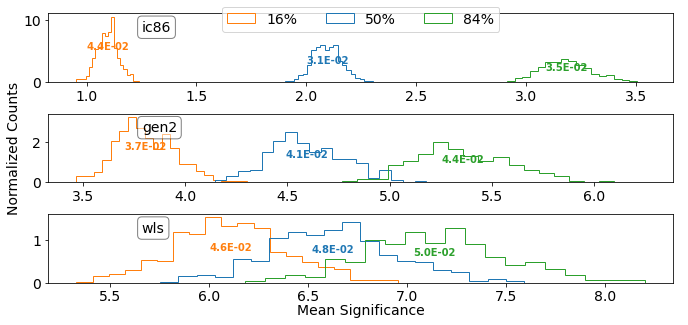

In [4]:
trials = 1000
repetitions = 500
boot.run(trials=trials, repetitions=repetitions, mode = "generate")
fig, ax = plot_bootstrap(boot.zscore)
fig.savefig("./plots/bootstrapping/bootstrapping_lognorm_samples_{:1.0e}_trials_{}_reps_{}.pdf".format(samples, trials, repetitions))

BOOTSTRAPPING -- TRIALS 10000 -- REPETITIONS 500
Detector: ic86


100%|██████████| 500/500 [00:02<00:00, 232.80it/s]


Detector: gen2


100%|██████████| 500/500 [00:02<00:00, 197.47it/s]


Detector: wls


100%|██████████| 500/500 [00:02<00:00, 199.89it/s]


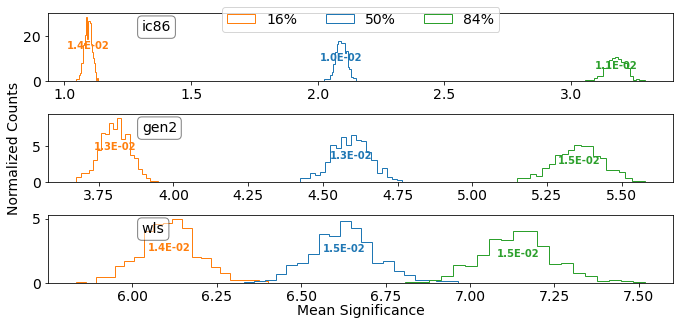

In [5]:
trials = 10000
repetitions = 500
boot.run(trials=trials, repetitions=repetitions, mode = "generate")
fig, ax = plot_bootstrap(boot.zscore)
fig.savefig("./plots/bootstrapping/bootstrapping_lognorm_samples_{:1.0e}_trials_{}_reps_{}.pdf".format(samples, trials, repetitions))

BOOTSTRAPPING -- TRIALS 100000 -- REPETITIONS 500
Detector: ic86


100%|██████████| 500/500 [00:14<00:00, 33.88it/s]


Detector: gen2


100%|██████████| 500/500 [00:18<00:00, 27.23it/s]


Detector: wls


100%|██████████| 500/500 [00:18<00:00, 26.98it/s]


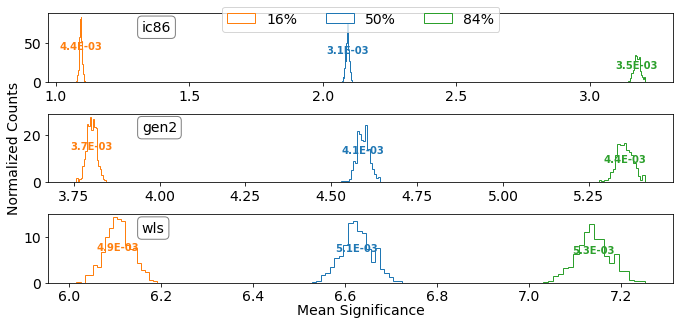

In [6]:
trials = 100000
repetitions = 500
boot.run(trials=trials, repetitions=repetitions, mode = "generate")
fig, ax = plot_bootstrap(boot.zscore)
fig.savefig("./plots/bootstrapping/bootstrapping_lognorm_samples_{:1.0e}_trials_{}_reps_{}.pdf".format(samples, trials, repetitions))

REALDEAL
Detector: ic86


100%|██████████| 500/500 [00:00<00:00, 1488.05it/s]


Detector: gen2


100%|██████████| 500/500 [00:00<00:00, 1486.12it/s]


Detector: wls


100%|██████████| 500/500 [00:00<00:00, 1437.40it/s]


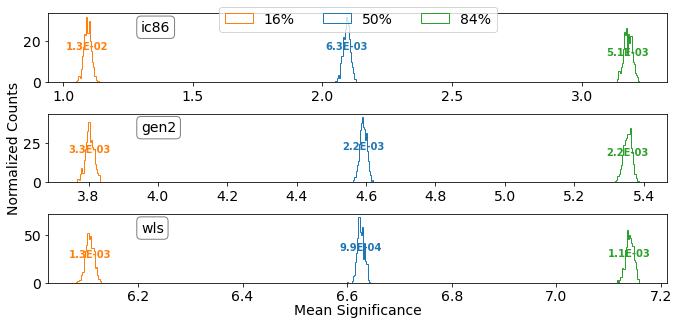

In [7]:
trials = 10000
repetitions = 500
boot.realdeal(trials=trials, repetitions=repetitions)
fig, ax = plot_bootstrap(boot.zscore)
fig.savefig("./plots/bootstrapping/realdeal_lognorm_samples_{:1.0e}_trials_{}_reps_{}.pdf".format(samples, trials, repetitions))

In [151]:
def bpl(a, x0, alpha, beta, k, x_hist):
    return a * ((x_hist**alpha)/x0)**(1/k) * (x_hist**beta)/x0

def bpl2(a, b, c, d, x_break, x_hist):
    y = []
    for x in x_hist:
        if x < x_break:
            y.append(a * (x ** b))
        else:
            y.append(c * (x ** d))
    return np.array(y)

In [152]:
def loss_bpl(x, args):
    x_hist, y_hist = args
    
    loss = np.sqrt(np.sum((bpl(*x, x_hist)-y_hist)**2))
    return loss

In [4]:
from scipy.optimize import minimize
from scipy.stats import loggamma, lognorm, gamma, skewnorm

det = "ic86"
ts = boot.ts
skewnorm_fit = skewnorm(*skewnorm.fit(ts[det]["null"]))
#logskew_fit = skewnorm(*skewnorm.fit(np.log10(ts[det]["null"][:100000])))
lognorm_fit = lognorm(*lognorm.fit(ts[det]["null"]))
#loggamma_fit = loggamma(*loggamma.fit(ts[det]["null"][:100000]))
#gamma_fit = gamma(*gamma.fit(ts[det]["null"][:100000]))

#x_fit = np.linspace(100,20000)
#res = minimize(loss_bpl, x0 = (1,1,1,1,1), args = [x_null, np.log10(y_null)], method="Nelder-Mead")
#bpl_fit = bpl(*res.x, x_fit)


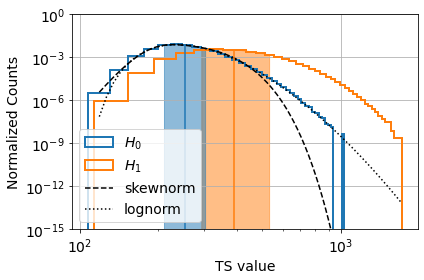

In [224]:
# Plot TS distribution for null and signal hypothesis for gen2

bins = 40

# get 16, 50, 86% of TS distribution
ps_null = np.percentile(ts[det]["null"], [16, 50, 84])
ps_signal = np.percentile(ts[det]["signal"], [16, 50, 84])

fig, ax = plt.subplots(1,1)

hist_null = plt.hist(ts[det]["null"], histtype="step", density=True, bins = bins, color = 'C0', lw = 2, label = r"$H_0$")
hist_signal = plt.hist(ts[det]["signal"], histtype="step", density=True, bins = bins, color = 'C1', lw = 2, label = r"$H_1$")

# get histogram bins and values
bin_null, bin_signal = hist_null[1], hist_signal[1]
y_null, y_signal = hist_null[0], hist_signal[0]
# get x values
x_null, x_signal = (bin_null[1:]+bin_null[:-1])/2, (bin_signal[1:]+bin_signal[:-1])/2


# get fitted background distribution
x_fit = np.linspace(np.minimum(x_null[0],x_signal[0]), np.maximum(x_null[-1],x_signal[-1]), 200)
y_skewnorm = skewnorm_fit.pdf(x_fit)

y_lognorm = lognorm_fit.pdf(x_fit)


# mask range of 16% and 84% quantiles
mask_null = np.logical_and(x_null > ps_null[0], x_null < ps_null[2])
mask_signal = np.logical_and(x_signal > ps_signal[0], x_signal < ps_signal[2])

# Search for the heights of the bins in which the percentiles are
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-15,1)
_, ymax = ax.get_ybound()

hi_null = y_null[np.searchsorted(x_null, ps_null, side='left')-1]
hi_signal = y_signal[np.searchsorted(x_signal, ps_signal, side='left')-1]

ax.plot(x_fit, y_skewnorm, "k--", label = "skewnorm")
ax.plot(x_fit, y_lognorm, "k:", label = "lognorm")

ax.vlines(ps_null[1], ymin = 0, ymax = hi_null[1], color = 'C0', ls = '-')
ax.vlines(ps_signal[1], ymin = 0, ymax = hi_signal[1], color = 'C1', ls = '-')

ax.fill_between(x = x_signal[mask_signal], y1 = y_signal[mask_signal], color = 'C1', alpha = 0.5)
ax.fill_between(x = x_null[mask_null], y1 = y_null[mask_null], color = 'C0', alpha = 0.5)

ax.set_xlabel("TS value", fontsize = 14)
ax.set_ylabel("Normalized Counts", fontsize = 14)
ax.tick_params(labelsize = 14)
ax.grid()
ax.legend(fontsize = 14)

plt.tight_layout()

In [20]:
det = "ic86"
data = ts[det]["null"]

distributions = [skewnorm, lognorm]

for dist in distributions:

    dist_para = dist.fit(data)
    dist_fit = dist(*dist_para)
    ks_stat, ks_pvalue = kstest(data, dist.rvs(dist_para[2], loc = dist_para[0], scale = dist_para[1], size = len(data)))
    print(dist.name, ks_stat, ks_pvalue)


KstestResult(statistic=0.6063733, pvalue=0.0, statistic_location=180.51175586764822, statistic_sign=-1)
KstestResult(statistic=0.500757, pvalue=0.0, statistic_location=130.84912757097348, statistic_sign=-1)


In [254]:
class BrokenPowerLaw():

    def __init__(self) -> None:
        pass

    def _pdf_loss(self, para, args):
        x_hist, y_hist, mode = args
        y_fit = self.pdf(x_hist, para, mode)

        return np.sqrt(np.sum((y_fit-y_hist)**2))

    def fit(self, data, mode = None):

        y_hist, bin_hist = np.histogram(data, bins = int(np.sqrt(len(data))), density=True)
        x_hist = (bin_hist[1:]+bin_hist[:-1])/2

        x_break = np.log10(x_hist[np.argmax(y_hist)])

        para0 = [1E-2, 1, -1, x_break, 1]

        if mode is None or mode == "lin":
            args = [x_hist, y_hist, mode]

        elif mode == "log":
            args = [x_hist, np.log10(y_hist), mode]            
        
        res = minimize(self._pdf_loss, x0=para0, args=args, method = "Nelder-Mead")

        return res.x


    def pdf(self, x, para, mode = None):
        """_summary_

        Args:
            x (np.array): random variable
            para (list): parameters of broken power law
            mode (str or None, optional): For linear fit mode = "lin" or mode = "None". For log10 fit mode = "log". Defaults to None.

            parameters of broken power law
            a: normalization
            g1: spectral index before break
            g2: spectral index after break
            logx0: log10 of the random variable where the break happens
            curve: curvature (smoothness) of the break

        Returns:
            np.array: pdf
        """

        a, g1, g2, logx0, curve = para
        logx = np.log10(x)

        if mode is None or mode == "lin":
            return a * 10**(logx * g1) * (1 + (10 ** logx / 10 ** logx0) ** curve) ** ((g2 - g1) / curve)

        elif mode == "log":
            return a + g1 * logx + (g2 - g1) / curve * np.log10(1 + (10 ** logx / 10 ** logx0) ** curve)

In [255]:
data = boot.ts["ic86"]["null"]

y_hist, bin_hist = np.histogram(data, bins = int(np.sqrt(len(data))), density=True)
x_hist = (bin_hist[1:]+bin_hist[:-1])/2

In [260]:
from scipy.optimize import minimize
bpl = BrokenPowerLaw()
bpl_fit = bpl.fit(data, mode = "lin")

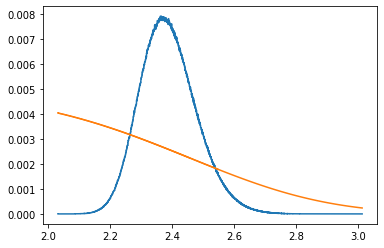

In [261]:
plt.step(np.log10(x_hist), y_hist, label = "data")
plt.step(np.log10(x_hist), bpl.pdf(x_hist, para=bpl_fit, mode = "lin"), label = "fit")

In [259]:
np.log10(y_hist)

/tmp/ipykernel_4783/120643793.py:1: RuntimeWarning: divide by zero encountered in log10
  np.log10(y_hist)


array([-6.46597512,        -inf, -6.46597512, ...,        -inf,
              -inf, -6.46597512])